In [100]:
import numpy as np
import pandas as pd 
import os
import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import array
from keras.utils import to_categorical
from numpy import argmax
from keras import Sequential
from keras.layers import LSTM,Input,Lambda,concatenate, Dense,Dropout,GRU,BatchNormalization
from keras.utils import to_categorical
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text as keras_text, sequence as keras_seq
import re
import keras.backend as K
from keras.models import Model
from keras.optimizers import Adadelta
from time import time
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
import tensorflow as tf
from keras import optimizers

In [ ]:
def ReadData():
    train1 = pd.read_csv("../input/train.csv",encoding ='latin1')
    test1 = pd.read_csv("../input/test.csv",encoding ='latin1')
    desc1 = pd.read_csv("../input/product_descriptions.csv",encoding ='latin1')
    sample1 = pd.read_csv("../input/sample_submission.csv",encoding ='latin1')
    attributes1 = pd.read_csv("../input/attributes.csv",encoding ='latin1')
    return train1,test1,desc1,sample1,attributes1
def ConcatDescAndTitle(df):
    train1 = df.merge(desc,on='product_uid',how='left')
    #train1['TitleAndDesc'] = train1[['product_title', 'product_description']].apply(lambda x: ''.join(x), axis=1)
    train1 = train1.drop(columns=['product_description','id','product_uid'])
    #train1['product_title'] = train1['product_title'].str.replace('[^a-zA-Z0-9\s]','$')
    #train1['search_term'] = train1['search_term'].str.replace('[^a-zA-Z0-9\s]','$')
    train1['product_title'] = train1['product_title'].str.replace('\\xa0', '')
    train1['search_term'] = train1['search_term'].str.replace('\\xa0', '')
    return train1
def LeftRightAndY(df):
    left = df["product_title"]
    right = df["search_term"]
    y = df["relevance"]
    return left,right,y

In [ ]:
train,test,desc,sample,attributes = ReadData()
train = ConcatDescAndTitle(train)
test = ConcatDescAndTitle(test)

#input_left,input_right,y = LeftRightAndY(train)

In [ ]:
train.head(50)

In [ ]:
def embd():
    chars = "abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
    sent3 = list()
    for i in range(train.shape[0]):
        sent3.append(list(train.loc[i]["product_title"]))
        sent3.append(list(train.loc[i]["search_term"]))
    for i in range(test.shape[0]):
        sent3.append(list(test.loc[i]["product_title"]))
        sent3.append(list(test.loc[i]["search_term"]))
    for i in range(len(sent3)):
        for j in range (len(sent3[i])):
            if sent3[i][j] not in chars:
                sent3[i][j] = '$'
    emb = 4
    model2 = Word2Vec(sent3, size=emb, window=5,negative=5,iter=10)
    return model2

**Creating the embd**

In [ ]:
model = embd()
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
plt.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

In [ ]:
def CreateDic():
    CharToIndex2 = {}
    counter=0
    for key in model.wv.vocab.keys():
        CharToIndex2[key] = counter
        counter += 1
    return CharToIndex2
def CreateOneHot(index):
    arr = np.zeros(lenthofchar)
    arr[index] = 1
    return arr

In [ ]:
avg = 0
for i in range(train.shape[0]):
    lis =(list(train.loc[i]["product_title"]))
    avg += len(lis)
avg_len = avg/train.shape[0]
print(avg_len)
CharToIndex = CreateDic()
avg_len =int(math.floor(avg_len))
x_train_left = np.empty([train.shape[0],avg_len,4])
for i in range(train.shape[0]):
    lis =(list(train.loc[i]["product_title"]))
    for j in range(avg_len):
        if (j<len(lis)):
            x_train_left[i][j] = X[CharToIndex[lis[j]]]
x_train_right = np.empty([train.shape[0],avg_len,4])
for i in range(train.shape[0]):
    lis2 =(list(train.loc[i]["search_term"]))
    for j in range(avg_len):
        if (j<len(lis2)):
            x_train_right[i][j] = X[CharToIndex[lis2[j]]]

In [ ]:
y_train=train["relevance"]
until = train.shape[0]*0.85
X_train = train.loc[:until,:]
X_test = train.loc[until:,:]
Y_train = y_train.loc[:until]
Y_test = y_train.loc[until:]
avg = 0
chars = "abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
for i in range(X_train.shape[0]):
    lis =(list(X_train.loc[i]["product_title"]))
    avg += len(lis)
avg_len = avg/X_train.shape[0]
avg_len =int(math.floor(avg_len))
avg_len=60
lenthofchar = len(chars)
x_train_left = np.empty([X_train.shape[0],avg_len,lenthofchar])
for i in range(X_train.shape[0]):
    lis =(list(X_train.loc[i]["product_title"]))
    for j in range(avg_len):
        if (j<len(lis)):
            x_train_left[i][j] = CreateOneHot(chars.find(lis[j]))
        else:
            x_train_left[i][j] = CreateOneHot(chars.find("$"))
x_train_right = np.empty([X_train.shape[0],avg_len,lenthofchar])
for i in range(X_train.shape[0]):
    lis2 =(list(X_train.loc[i]["search_term"]))
    for j in range(avg_len):
        if (j<len(lis2)):
            x_train_right[i][j] = CreateOneHot(chars.find(lis2[j]))
        else:
            x_train_right[i][j] = CreateOneHot(chars.find("$"))

In [ ]:
def exponent_neg_manhattan_distance(left, right):
    x =  K.sqrt(K.sum(K.pow(left-right,2), axis=1, keepdims=True))
    return x+2.5

In [ ]:
y_binary = to_categorical(y_train)

**THE LSTM NetWork**

In [101]:
n_hidden = 150
batch_size = 1500
n_epoch = 3
left_input = Input(shape=(x_train_left.shape[1], x_train_left.shape[2]))
right_input = Input(shape=(x_train_left.shape[1], x_train_left.shape[2]))
shared_lstm = LSTM(n_hidden)

left_out = shared_lstm(left_input)
right_out = shared_lstm(right_input)
left_out_norm = BatchNormalization()(left_out)
right_out_norm = BatchNormalization()(right_out)
merged_vector = concatenate([left_out_norm, right_out_norm], axis=-1)
#malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (1, 1))([left_out, right_out])
predictions2 = Dense(10,activation="relu")(merged_vector)
predictions = Dense(1,activation="linear")(predictions2)
# Pack it all up into a model
malstm = Model([left_input, right_input], [predictions])

optimizer = Adadelta(clipnorm=1.25)
#malstm.compile(loss='mse', optimizer="adam", metrics=['accuracy'])
sgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

malstm.compile( loss = "mse", 
               optimizer = "adam", 
               metrics=['accuracy']
             )
malstm.summary()
# Start training
training_start_time = time()

malstm_trained = malstm.fit([x_train_left, x_train_right],Y_train, batch_size=batch_size, nb_epoch=n_epoch,validation_split=0.05)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_91 (InputLayer)           (None, 60, 63)       0                                            
__________________________________________________________________________________________________
input_92 (InputLayer)           (None, 60, 63)       0                                            
__________________________________________________________________________________________________
lstm_23 (LSTM)                  (None, 150)          128400      input_91[0][0]                   
                                                                 input_92[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 150)          600         lstm_23[0][0]                    
__________

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 59809 samples, validate on 3148 samples
Epoch 1/3
59809/59809 [==============================] - 126s 2ms/step - loss: 0.9765 - acc: 0.1708 - val_loss: 1.1171 - val_acc: 0.1112
Epoch 2/3
59809/59809 [==============================] - 109s 2ms/step - loss: 0.3062 - acc: 0.1958 - val_loss: 0.3607 - val_acc: 0.1588
Epoch 3/3
59809/59809 [==============================] - 109s 2ms/step - loss: 0.2937 - acc: 0.1950 - val_loss: 0.2955 - val_acc: 0.2097


In [ ]:
avg = 0
val = int(math.floor(until))+X_test.shape[0]
x_test_left = np.empty([X_test.shape[0],avg_len,lenthofchar])
for i in range(int(math.floor(until))+1,val):
    lis =(list(X_test.loc[i]["TitleAndDesc"]))
    for j in range(avg_len):
        if (j<len(lis)):
            if ([lis[j]]!='\xa0'):
                x_test_left[i-int(math.floor(until))-1][j] = CreateOneHot(chars.find(lis[j]))
            else:
                x_test_left[i-int(math.floor(until)-1)][j] =  CreateOneHot(chars.find("$")) 
x_test_right = np.empty([X_test.shape[0],avg_len,lenthofchar])
for i in range(int(math.floor(until))+1,val):
    lis2 =(list(X_test.loc[i]["search_term"]))
    for j in range(avg_len):
        if (j<len(lis2)):
            if ([lis2[j]]!='\xa0'):
                x_test_right[i-int(math.floor(until))-1][j] = CreateOneHot(chars.find(lis2[j]))
            else:
                x_test_right[i-int(math.floor(until))-1][j] = CreateOneHot(chars.find("$"))

In [ ]:
preds = malstm.predict([x_test_left, x_test_right], batch_size=batch_size)

In [ ]:
X_test.shape[0]

**Good One:**

In [ ]:
val = int(math.floor(until))+X_test.shape[0]
x_test_left = np.empty([X_test.shape[0],60,lenthofchar])
for i in range(int(math.floor(until))+1,val):
    lis =(list(X_test.loc[i]["product_title"]))
    for j in range(60):
        if (j<len(lis)):
            if ([lis[j]]!='\xa0'):
                x_test_left[i-int(math.floor(until))-1][j] = CreateOneHot(chars.find(lis[j]))
            else:
                x_test_left[i-int(math.floor(until)-1)][j] =  CreateOneHot(chars.find("$")) 
x_test_right = np.empty([X_test.shape[0],60,lenthofchar])
for i in range(int(math.floor(until))+1,val):
    lis2 =(list(X_test.loc[i]["search_term"]))
    for j in range(60):
        if (j<len(lis2)):
            if ([lis2[j]]!='\xa0'):
                x_test_right[i-int(math.floor(until))-1][j] = CreateOneHot(chars.find(lis2[j]))
            else:
                x_test_right[i-int(math.floor(until))-1][j] = CreateOneHot(chars.find("$"))

In [102]:
preds = malstm.predict([x_test_left, x_test_right], batch_size=batch_size)

Test RMSE: 0.556
Test MAE: 0.440


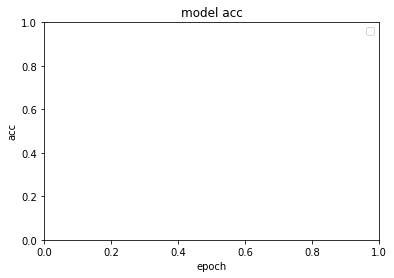

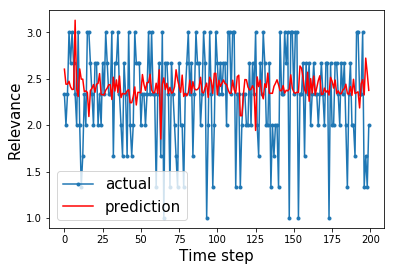

In [103]:
rmse = np.sqrt(mean_squared_error(preds, Y_test))
MAE = mean_absolute_error(preds, Y_test)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % MAE)
#plt.plot(malstm_trained.history['acc'])
#plt.plot(malstm_trained.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
aa=[x for x in range(200)]
plt.plot(aa, Y_test[:200], marker='.', label="actual")
plt.plot(aa, preds[:200], 'r', label="prediction")
plt.ylabel('Relevance', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

In [ ]:
sample["relevance"] = preds
sample.head(50)